# Case study: Data Fusion

This case study aims to demonstrate the uniqueness of the data fusion - based workflow of ChemFuseKit for a unitary prediction and analysis. As a real-world example, a dataset containing data from three different sensors will be used to train a classifier able to distinguish between dimethyl methylphosphonate (DMMP) and acetone samples. The objective is to create a single, uninterrupted pipeline from the datasheets to the creation of the classifier and its export as a reusable model.

## Data Fusion

The samples in the dataset need to be aligned and checked manually by the user, as requested by the RISEN specification. In this case, some DMMP samples in the IMS table were not correctly sorted by sample id, while the acetone samples recorded in the GC and QEPAS data did not match in all cases, so that only the intersection was kept.

The spectral data obtained from the IMS and QEPAS sensors are most effective when rescaled through normalization. This process ensures that the data is consistent and comparable across different samples. Additional data processing techniques, such as Savitski-Golay smoothing, may be employed to further reduce noise and filter out any outliers in the data. However, for the purpose of this case study, only normalization will be applied to the IMS and QEPAS data.

On the other hand, the GC data does not require any preprocessing. The data obtained from the GC sensor is already in a usable format and can be directly integrated with the data from the other sensors.

The most significant aspect of data preprocessing in this case study is data fusion. The three tables contained in the Excel datasheet are concatenated row-wise to form a single table that contains the data from the IMS and QEPAS spectrometers, as well as the GC retention times.

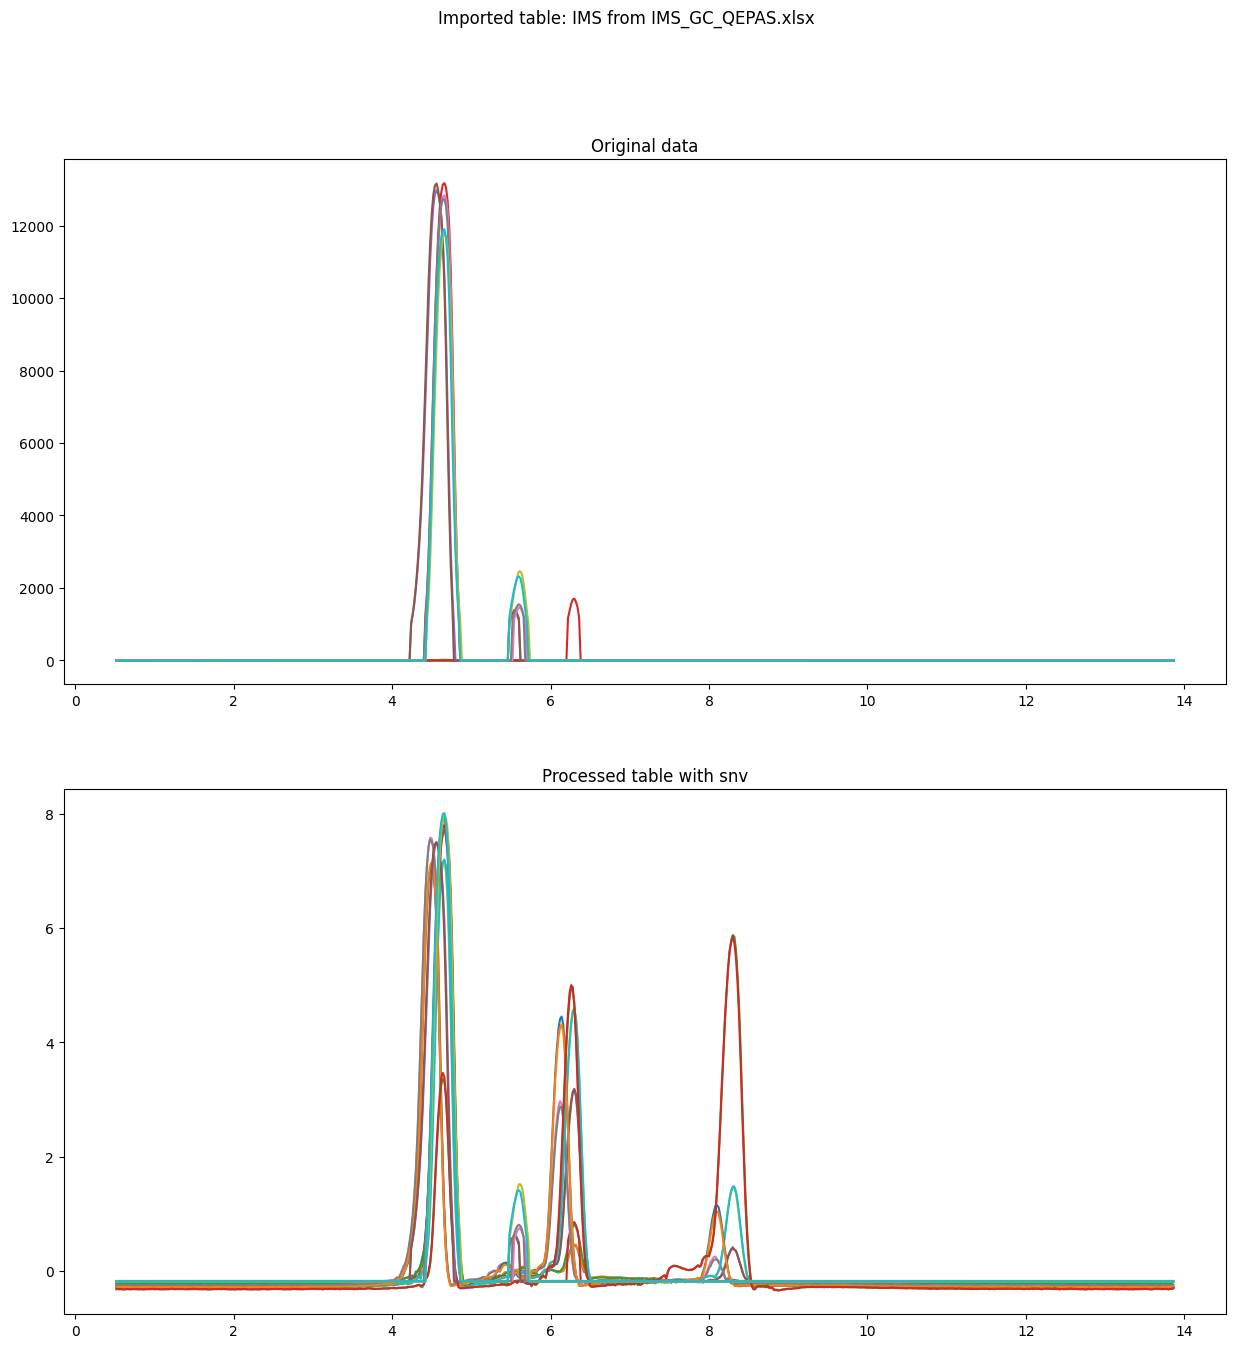

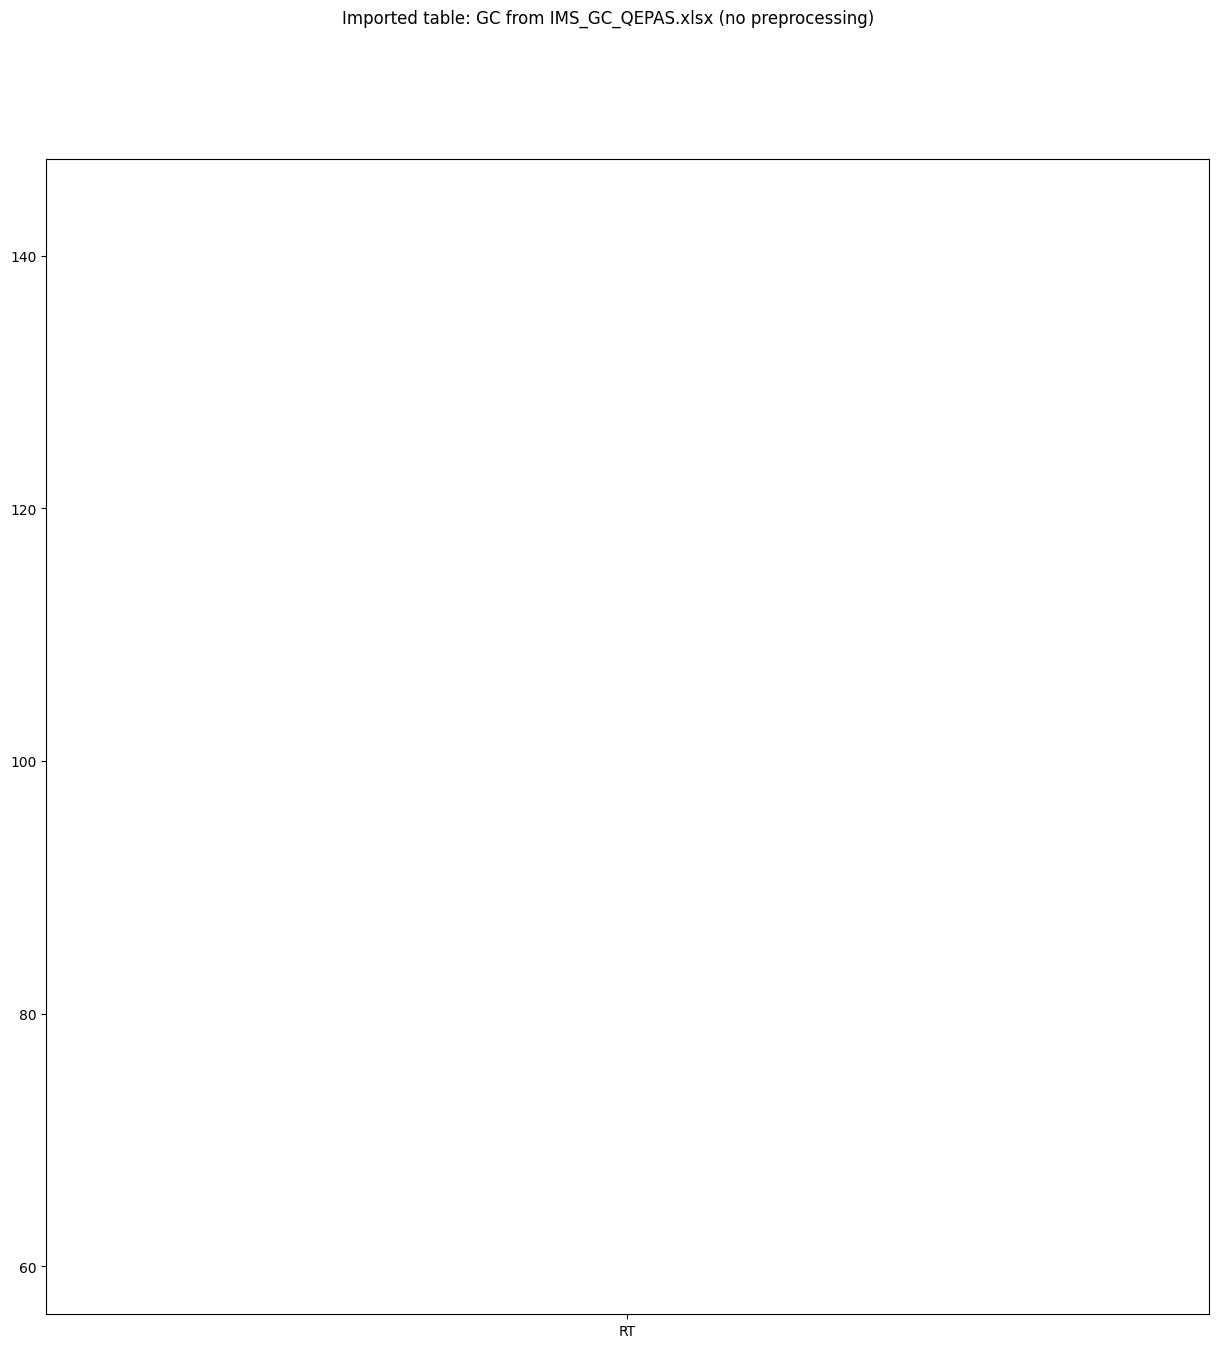

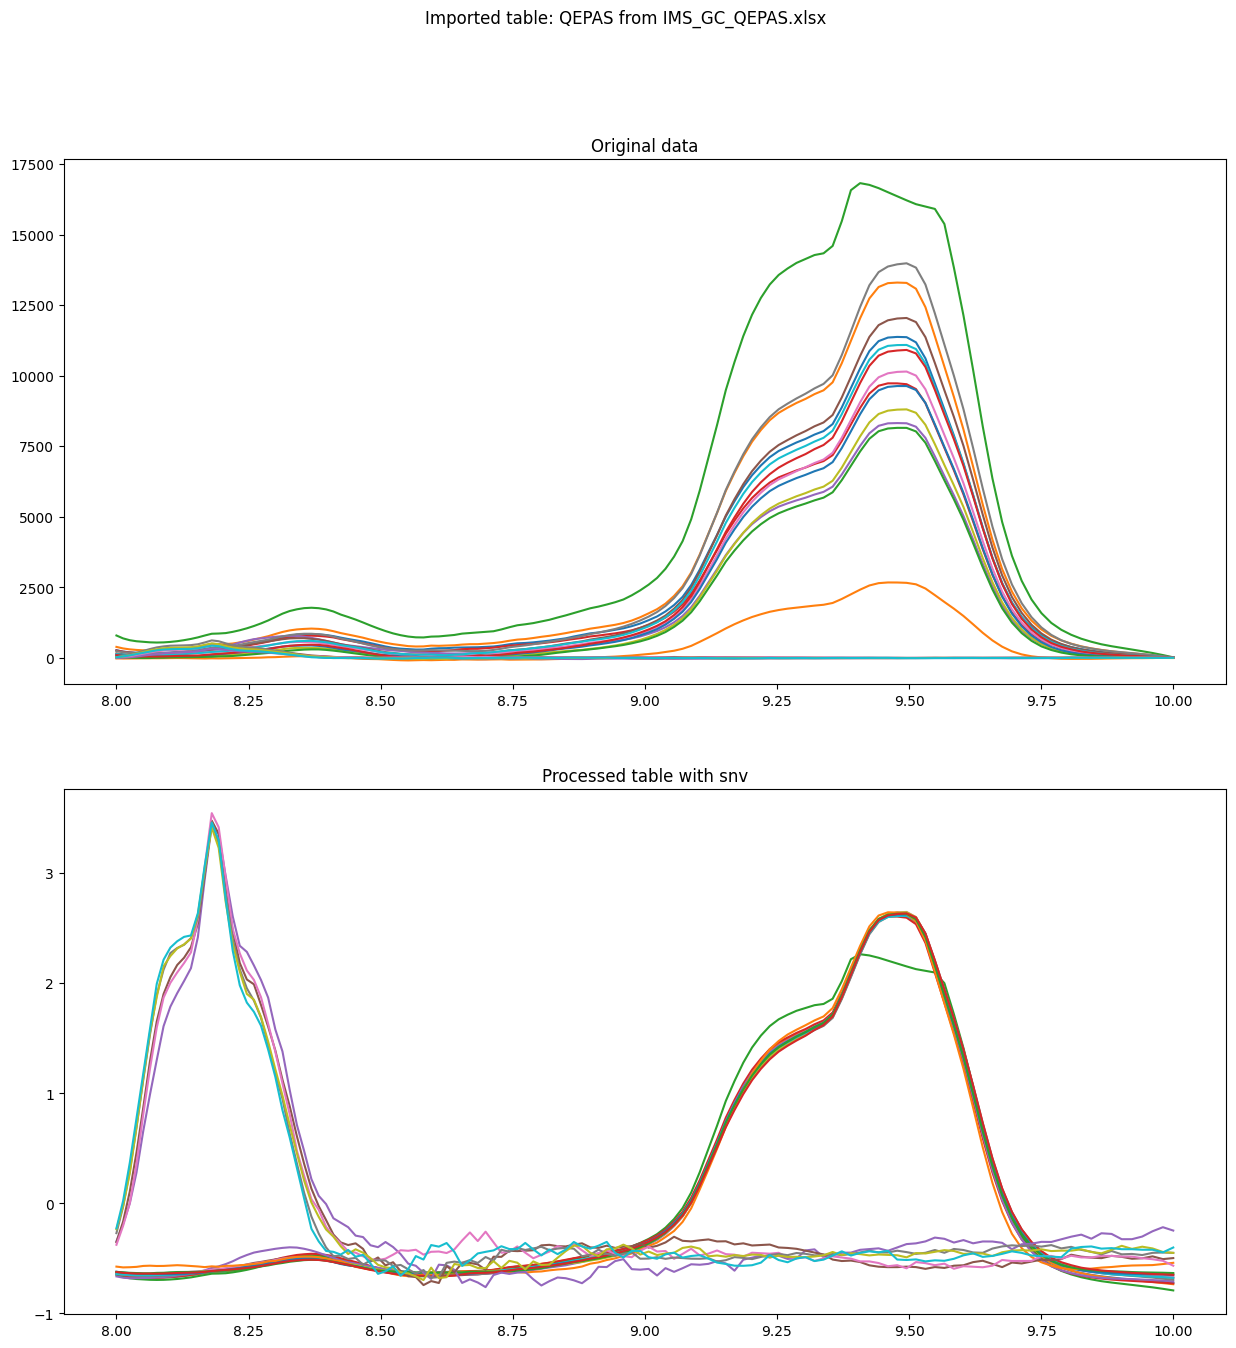

In [1]:
from chemfusekit.df import DFSettings, DF, Table

# Initialize the settings to produce graphical output for the operation
settings = DFSettings(output='graphical')

# Set up the import settings for the first table (IMS spectral data)
table1 = Table(
    file_path='IMS_GC_QEPAS.xlsx',
    sheet_name='IMS',
    preprocessing='snv',
    class_column='Class',
    index_column='Sample_id'
)

# Set up the import settings for the second table (GC chromatography data)
table2 = Table(
    file_path='IMS_GC_QEPAS.xlsx',
    sheet_name='GC',
    preprocessing='none',
    class_column='Class',
    index_column='Sample_id'
)

# Set up the import settings for the third table (QEPAS spectral data)
table3 = Table(
    file_path='IMS_GC_QEPAS.xlsx',
    sheet_name='QEPAS',
    preprocessing='snv',
    class_column='Class',
    index_column='Sample_id'
)

# Now, let's make an array of the two tables
tables = [table1, table2, table3]

# Let's pass the settings and the tables to the LLDF constructor
df = DF(settings, tables)

# Let's finally perform data fusion with the lldf() method!
df.fuse()

## Dimensionality reduction

The resulting fused dataset is characterized by a very high dimensionality (hundreds of components). Many of these components are highly collinear, due to the nature of the spectral data (the values represent responses in specific bands, and those bands overlap partially). We can attempt a reduction of dimensionality while retaining the most amount of usable information by running PCA on the dataset.

The resulting fused dataset is characterized by a very high dimensionality, with hundreds of components, many of which are highly collinear due to the partial overlap of the spectral data bands. To address this issue and retain the most amount of usable information, we can attempt a reduction of dimensionality by running Principal Component Analysis (PCA) on the dataset. PCA is a statistical technique used to simplify high-dimensional data by transforming the original data into a new set of variables called principal components, which are linear combinations of the original variables. The first principal component captures the direction of the largest variability in the data, the second principal component captures the remaining variability orthogonal to the first component, and so on. By retaining only the first few principal components, one can often capture most of the information in the original data with fewer variables, making it easier to visualize and analyze.

In our case, we will set the PCA analysis to automatically select the number of components required to explain 99% of the original variance in the data, with a maximum limit of 10 components. If the target variance can be achieved with fewer than 10 components, the PCA analysis will use that lower number. Otherwise, all 10 will be utilized. Tests will be run with a 95% confidence interval.

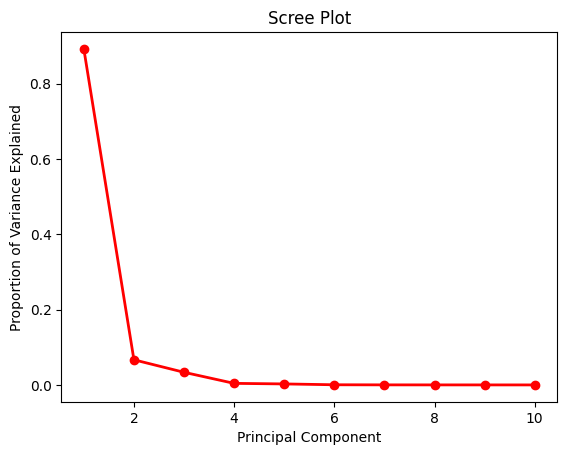

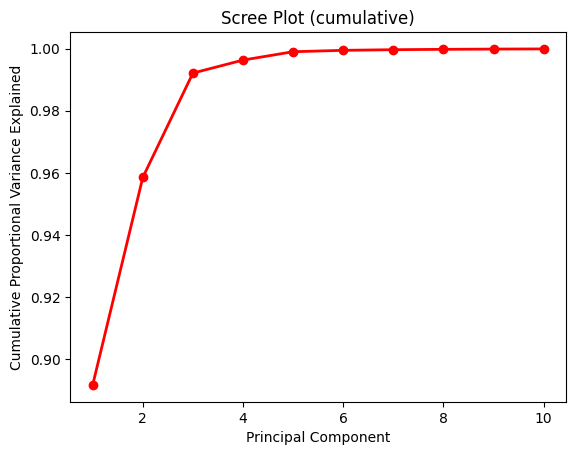

In [2]:
from chemfusekit.pca import PCASettings, PCA

# Retrieve the fused data from the lldf object of the previous step
fused_data = df.fused_data

# Initialize the settings for PCA with graph output
pca_settings = PCASettings(
    target_variance=0.99,
    confidence_level=0.95,
    initial_components=10,
    output='graphical'
)

# Initialize and run PCA on the fused dataset
pca = PCA(pca_settings, fused_data)
pca.train()

# Run the tests and statistics
pca.pca_stats()

# Get the data
reduced_dataset = pca.export_data()

## Model training

To classify our data, we will utilize a LR (Logistic Regression) object. The LR class is designed to automatically recognize the type of data it is provided with. In the case of receiving a PCADataModel object, it will default to using the array_scores as its x regressor for the logistic regression model.

The LR model is configured to perform split testing, with 70% of the data allocated for the training set and the remaining 30% for the evaluation set. Upon completion of the model training, the confusion matrix and classification report indicate promising results.

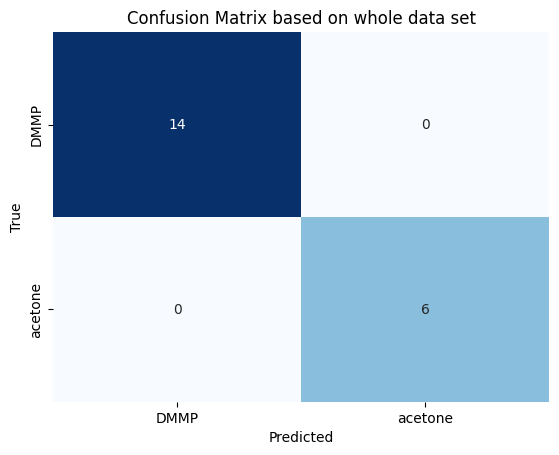

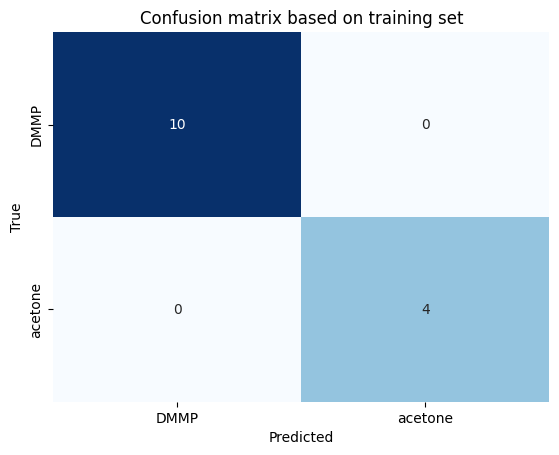

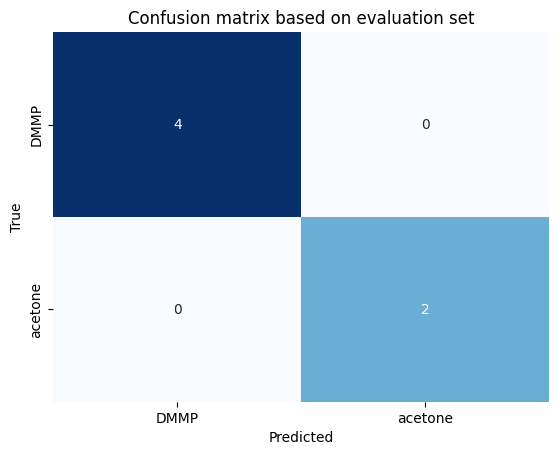

In [3]:
from chemfusekit.lr import LRSettings, LR

# Initialize the settings to produce graph output and perform split testing
lr_settings = LRSettings(output='graphical', test_split=True)

# Initialize and train LR
lr = LR(lr_settings, reduced_dataset)
lr.train()

## Model export

The `LR` model can be exported using the `export_model(export_path: str)` method, which is inherited from its parent class `BaseClassifier` due to `LR` being a classifier itself.

The `PCA` model can be exported too.

In [4]:
lr.export_model("LR_DMMP_acetone_classifier.sklearn")
pca.export_model("DMMP_acetone_pca.sklearn")

In the future, when we need to classify DMMP and acetone on a new dataset, we can simply import the new dataset, perform the necessary data fusion, reduce the dimensionality through PCA, import the pre-trained `LR` model, and use it to classify the data. This streamlined process allows for efficient and consistent classification of DMMP and acetone samples.

/Volumes/Federico/TESY/progetto/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Volumes/Federico/TESY/progetto/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


['acetone']


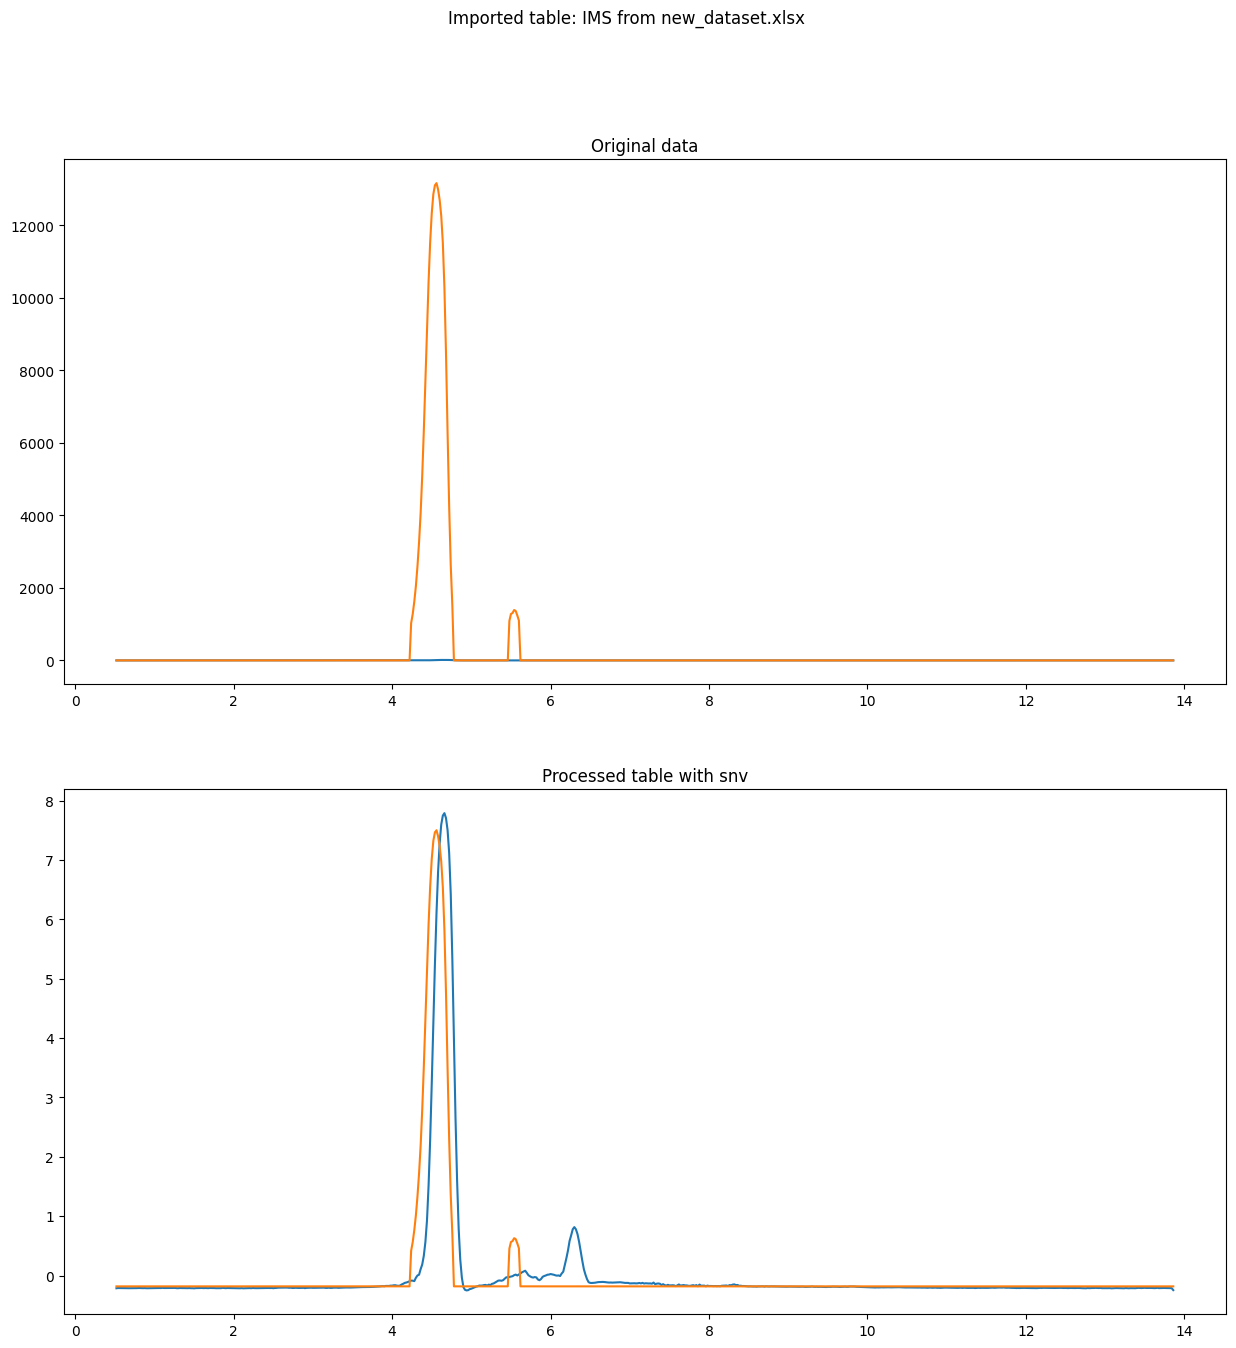

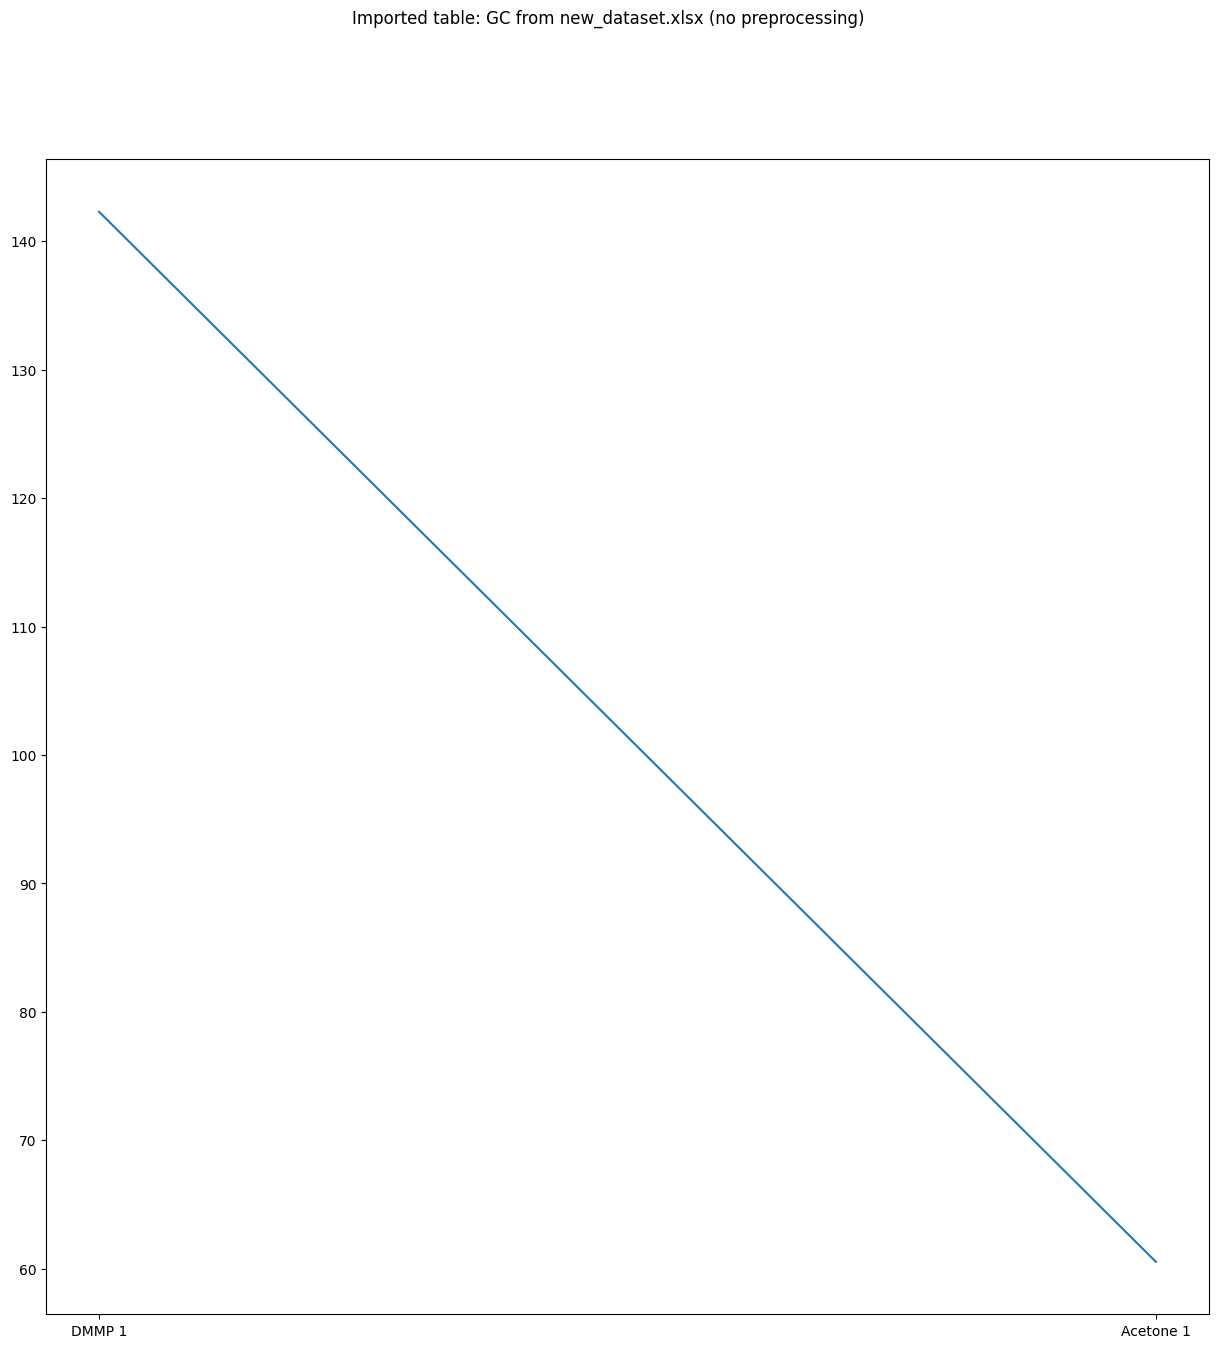

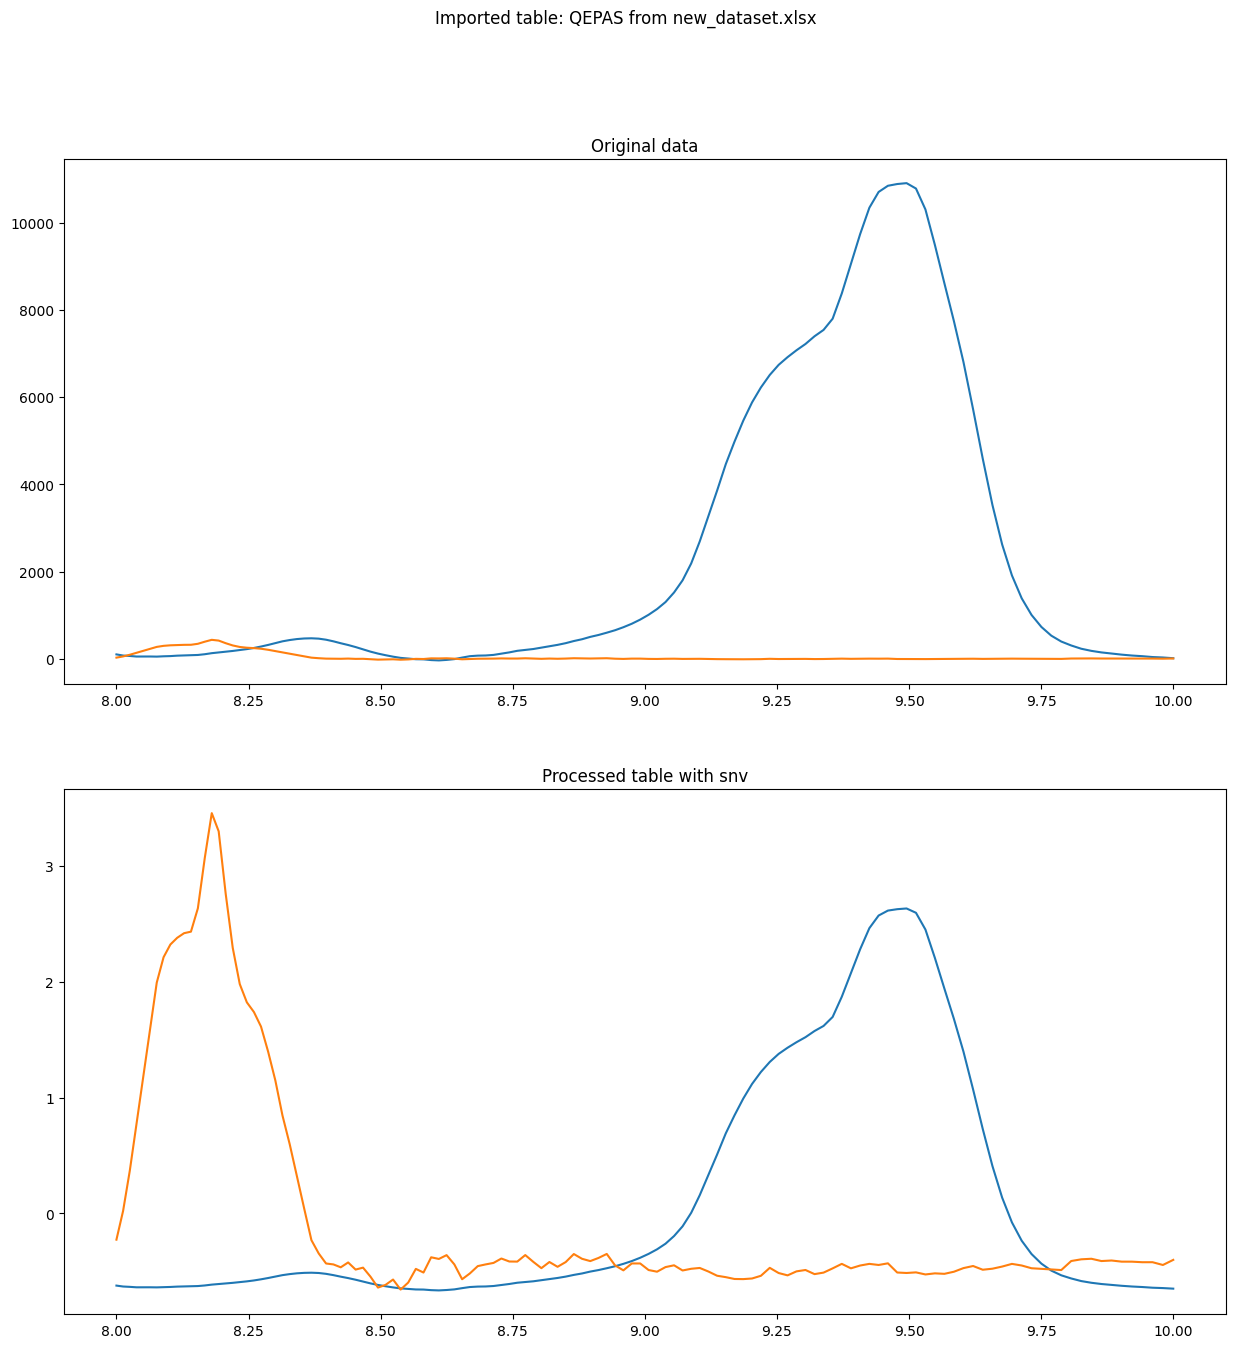

In [1]:
from chemfusekit.df import DFSettings, DF, Table
from chemfusekit.pca import PCASettings, PCA
from chemfusekit.lr import LRSettings, LR

# Data fusion
df_settings = DFSettings(output='graphical')
table1 = Table(
    file_path='new_dataset.xlsx',
    sheet_name='IMS',
    preprocessing='snv',
    class_column='Class',
    index_column='Sample_id'
)
table2 = Table(
    file_path='new_dataset.xlsx',
    sheet_name='GC',
    preprocessing='none',
    class_column='Class',
    index_column='Sample_id'
)
table3 = Table(
    file_path='new_dataset.xlsx',
    sheet_name='QEPAS',
    preprocessing='snv',
    class_column='Class',
    index_column='Sample_id'
)
tables = [table1, table2, table3]
df = DF(df_settings, tables)
df.fuse()
fused_data = df.fused_data

# PCA
pca_settings = PCASettings()
pca = PCA.from_file(pca_settings, "DMMP_acetone_pca.sklearn")
reduced_data = pca.reduce(fused_data)

# LR
lr_settings = LRSettings(output='graphical')
lr = LR.from_file(lr_settings, "LR_DMMP_acetone_classifier.sklearn")
prediction = lr.predict(reduced_data[1])
print(prediction)